# Basic Setup

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [36]:
file_path = '/Users/gurkeinan/semester6/Causal-Inference/Project/code/data/processed_data.csv'
data = pd.read_csv(file_path)

data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,...,Admission grade,Displaced,Educational special needs,Gender,Scholarship holder,Unemployment rate,Inflation rate,GDP,Target,Adult
0,1,17,5,171,1,Complete Secondary Education,122.0,Incomplete Secondary Education,Complete Secondary Education,Administrative,...,127.3,1,0,1,0,10.8,1.4,1.74,0,0
1,1,15,1,9254,1,Complete Secondary Education,160.0,Complete Secondary Education,Higher Education - Undergraduate,Professionals,...,142.5,1,0,1,0,13.9,-0.3,0.79,1,0
2,1,1,5,9070,1,Complete Secondary Education,122.0,Other Specific Qualifications,Other Specific Qualifications,Plant and Machine Operators,...,124.8,1,0,1,0,10.8,1.4,1.74,0,0
3,1,17,2,9773,1,Complete Secondary Education,122.0,Other Specific Qualifications,Other Specific Qualifications,Administrative,...,119.6,1,0,0,0,9.4,-0.8,-3.12,1,0
4,2,39,1,8014,0,Complete Secondary Education,100.0,Other Specific Qualifications,Other Specific Qualifications,Plant and Machine Operators,...,141.5,0,0,0,0,13.9,-0.3,0.79,1,1


In [37]:
n = len(data)

t = data['Adult']
y = data['Target']
X = data.drop(columns=['Adult', 'Target'])

numerical_columns = ['Previous qualification (grade)', 'Admission grade', 'Unemployment rate', 'Inflation rate', 'GDP']
categorical_columns = list(set(X.columns) - set(numerical_columns))

# Scaling numerical columns
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# One-hot encoding for categorical columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Combine features and treatment variable
X_full = pd.concat([X, t], axis=1)

In [38]:
method_results = {}
method_CIs = {}
method_bootstrap_values = {}

# ROC Curve for $Y \mid X, t$

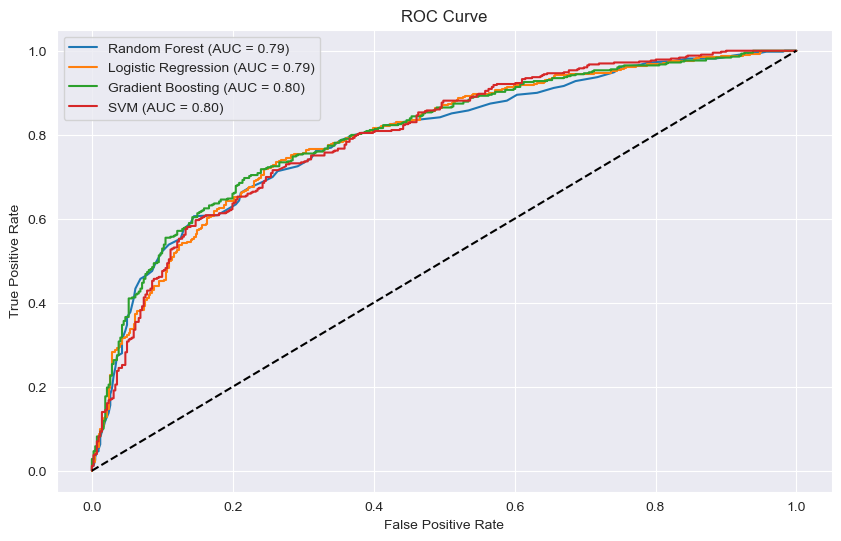

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Fit a Random Forest Classifier model to predict the target variable
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# Fit a Logistic Regression model to predict the target variable
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

# Fit a Gradient Boosting Classifier model to predict the target variable
model_gb = GradientBoostingClassifier(random_state=42)   
model_gb.fit(X_train, y_train)

# Fit an SVM model to predict the target variable
model_svm = SVC(probability=True, random_state=42)
model_svm.fit(X_train, y_train)


# Make predictions for test data 
y_pred_rf = model_rf.predict_proba(X_test)[:, 1]
y_pred_lr = model_lr.predict_proba(X_test)[:, 1]
y_pred_gb = model_gb.predict_proba(X_test)[:, 1]
y_pred_svm = model_svm.predict_proba(X_test)[:, 1]

# Calculate the ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

# Calculate the ROC curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)

# Calculate the ROC curve for Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_gb)

# Calculate the ROC curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

We observe that Random Forest, Gradient Boosting and SVM have the highest AUC. Therefore, we choose Random Forest to predict the target variable given the feature set and the treatment.

# ROC Curve $T \mid X$

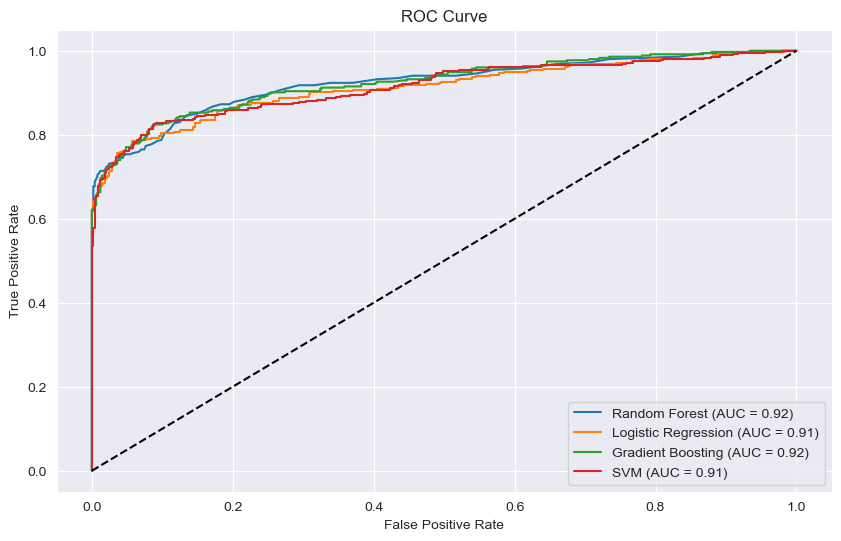

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.2, random_state=42)

# Fit a Random Forest Classifier model to predict the treatment variable
model_rf_t = RandomForestClassifier(random_state=42)
model_rf_t.fit(X_train, y_train)

# Fit a Logistic Regression model to predict the treatment variable
model_lr_t = LogisticRegression(random_state=42)
model_lr_t.fit(X_train, y_train)

# Fit a Gradient Boosting Classifier model to predict the treatment variable
model_gb_t = GradientBoostingClassifier(random_state=42)
model_gb_t.fit(X_train, y_train)

# Fit an SVM model to predict the treatment variable
model_svm_t = SVC(probability=True, random_state=42)
model_svm_t.fit(X_train, y_train)

# Make predictions for test data
y_pred_rf_t = model_rf_t.predict_proba(X_test)[:, 1]
y_pred_lr_t = model_lr_t.predict_proba(X_test)[:, 1]
y_pred_gb_t = model_gb_t.predict_proba(X_test)[:, 1]
y_pred_svm_t = model_svm_t.predict_proba(X_test)[:, 1]

# Calculate the ROC curve for Random Forest
fpr_rf_t, tpr_rf_t, _ = roc_curve(y_test, y_pred_rf_t)
roc_auc_rf_t = roc_auc_score(y_test, y_pred_rf_t)

# Calculate the ROC curve for Logistic Regression
fpr_lr_t, tpr_lr_t, _ = roc_curve(y_test, y_pred_lr_t)
roc_auc_lr_t = roc_auc_score(y_test, y_pred_lr_t)

# Calculate the ROC curve for Gradient Boosting
fpr_gb_t, tpr_gb_t, _ = roc_curve(y_test, y_pred_gb_t)
roc_auc_gb_t = roc_auc_score(y_test, y_pred_gb_t)

# Calculate the ROC curve for SVM
fpr_svm_t, tpr_svm_t, _ = roc_curve(y_test, y_pred_svm_t)
roc_auc_svm_t = roc_auc_score(y_test, y_pred_svm_t)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf_t, tpr_rf_t, label=f'Random Forest (AUC = {roc_auc_rf_t:.2f})')
plt.plot(fpr_lr_t, tpr_lr_t, label=f'Logistic Regression (AUC = {roc_auc_lr_t:.2f})')
plt.plot(fpr_gb_t, tpr_gb_t, label=f'Gradient Boosting (AUC = {roc_auc_gb_t:.2f})')
plt.plot(fpr_svm_t, tpr_svm_t, label=f'SVM (AUC = {roc_auc_svm_t:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

We observe that Random Forest, Gradient Boosting and SVM have the highest AUC. Therefore, we choose Random Forest to predict the target variable given the feature set and the treatment.

# Covariate Adjustment

## S-learner

In [41]:
# Fit a Random Forest Classifier model to predict the target variable
model = RandomForestClassifier(random_state=42)
model.fit(X_full, y)    

# Make predictions for all data points
y_pred_all = model.predict(X_full)

In [42]:
def calculate_measures_s_learner(X, y_pred_model):
    # Predict outcomes for all individuals under treatment condition
    X_treated = X.copy()
    X_treated['Adult'] = 1
    y_pred_treated = y_pred_model.predict_proba(X_treated)[:, 1]
    
    # Predict outcomes for all individuals under control condition
    X_control = X.copy()
    X_control['Adult'] = 0
    y_pred_control = y_pred_model.predict_proba(X_control)[:, 1]
    
    # Calculate individual treatment effects
    individual_effects = y_pred_treated - y_pred_control
    
    # Calculate ATE
    ATE = np.mean(individual_effects)
    
    # Calculate ATT
    ATT = np.mean(individual_effects[X['Adult'] == 1])
    
    # Calculate ATC
    ATC = np.mean(individual_effects[X['Adult'] == 0])
    
    return ATE, ATT, ATC

ATE, ATT, ATC = calculate_measures_s_learner(X_full, model)
print(f'ATE: {ATE:.4f}, ATT: {ATT:.4f}, ATC: {ATC:.4f}')
method_results['S-learner'] = {'ATE': ATE, 'ATT': ATT, 'ATC': ATC}

ATE: -0.0766, ATT: -0.0794, ATC: -0.0745


In [43]:
def bootstrap_confidence_intervals_s_learner(X, t, y, model, num_bootstrap=1000, ci_level=95):
    bootstrap_ATE = []
    bootstrap_ATT = []
    bootstrap_ATC = []
    
    # Combine X, t, and y into a single dataframe for easier resampling
    data = pd.concat([X, pd.Series(t, name='Adult'), pd.Series(y, name='Target')], axis=1)
    
    # Perform bootstrap sampling
    for i in range(num_bootstrap):
        # Create a bootstrap sample (resample with replacement)
        bootstrap_sample = data.sample(n=len(data), replace=True)
        
        # Split the bootstrap sample back into X, t, and y
        X_bootstrap = bootstrap_sample.drop(['Adult', 'Target'], axis=1)
        t_bootstrap = bootstrap_sample['Adult']
        y_bootstrap = bootstrap_sample['Target']
        
        # Refit the model on the bootstrap sample
        bootstrap_model = clone(model)  # Create a fresh copy of the model
        bootstrap_model.fit(pd.concat([X_bootstrap, t_bootstrap], axis=1), y_bootstrap)
        
        # Compute the ATE, ATT, and ATC for this bootstrap sample
        ATE, ATT, ATC = calculate_measures_s_learner(pd.concat([X_bootstrap, t_bootstrap], axis=1), bootstrap_model)
        
        # Store the results
        bootstrap_ATE.append(ATE)
        bootstrap_ATT.append(ATT)
        bootstrap_ATC.append(ATC)
    
    # Calculate percentiles for confidence intervals
    lower_percentile = (100 - ci_level) / 2
    upper_percentile = 100 - lower_percentile
    
    ATE_CI = np.percentile(bootstrap_ATE, [lower_percentile, upper_percentile])
    ATT_CI = np.percentile(bootstrap_ATT, [lower_percentile, upper_percentile])
    ATC_CI = np.percentile(bootstrap_ATC, [lower_percentile, upper_percentile])
    
    return ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC

# Usage
from sklearn.base import clone

ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC = bootstrap_confidence_intervals_s_learner(X, t, y, model)
print(f'ATE 95% CI: {ATE_CI}, ATT 95% CI: {ATT_CI}, ATC 95% CI: {ATC_CI}')
method_CIs['S-learner'] = {'ATE_CI': ATE_CI, 'ATT_CI': ATT_CI, 'ATC_CI': ATC_CI}
method_bootstrap_values['S-learner'] = {'ATE': bootstrap_ATE, 'ATT': bootstrap_ATT, 'ATC': bootstrap_ATC}

ATE 95% CI: [-0.09790951 -0.05612521], ATT 95% CI: [-0.10040724 -0.05892746], ATC 95% CI: [-0.09953683 -0.05133005]


## T-learner

In [44]:
X_1 = X[X_full['Adult'] == 1]
X_0 = X[X_full['Adult'] == 0]

y_1 = data[data['Adult'] == 1]['Target']
y_0 = data[data['Adult'] == 0]['Target']

# Fit a Random Forest Classifier model to predict the target variable for each subgroup
model_1 = RandomForestClassifier(random_state=42)
model_1.fit(X_1, y_1)

model_0 = RandomForestClassifier(random_state=42)
model_0.fit(X_0, y_0)

y_pred_all_1 = model_1.predict(X)
y_pred_all_0 = model_0.predict(X)

In [45]:
def calculate_measures_t_learner(data, y_pred_all_1, y_pred_all_0):
    treated_predictions_sum = sum(y_pred_all_1)
    control_predictions_sum = sum(y_pred_all_0)

    ATE = (treated_predictions_sum - control_predictions_sum) / n
    ATT = (sum(y_pred_all_1[data['Adult'] == 1]) -  sum(y_pred_all_0[data['Adult'] == 1])) / sum(t)
    ATC = (sum(y_pred_all_1[data['Adult'] == 0]) -  sum(y_pred_all_0[data['Adult'] == 0])) / (n - sum(t))

    return ATE, ATT, ATC

ATE, ATT, ATC = calculate_measures_t_learner(data, y_pred_all_1, y_pred_all_0)        
print(f'ATE: {ATE}, ATT: {ATT}, ATC: {ATC}')
method_results['T-learner'] = {'ATE': ATE, 'ATT': ATT, 'ATC': ATC}

ATE: -0.14874088020710755, ATT: -0.15284827975183304, ATC: -0.14579967689822293


In [46]:
def bootstrap_confidence_intervals_t_learner(data, y_pred_all_1, y_pred_all_0, num_bootstrap=1000, ci_level=95):
    bootstrap_ATE = []
    bootstrap_ATT = []
    bootstrap_ATC = []
    
    # Perform bootstrap sampling
    for i in range(num_bootstrap):
        # Create a bootstrap sample (resample with replacement)
        bootstrap_sample = data.sample(n=len(data), replace=True)
        
        # Get predictions for the bootstrap sample
        y_pred_bootstrap_1 = y_pred_all_1[bootstrap_sample.index]
        y_pred_bootstrap_0 = y_pred_all_0[bootstrap_sample.index]
        
        # Compute the ATE, ATT, and ATC for this bootstrap sample
        ATE, ATT, ATC = calculate_measures_t_learner(bootstrap_sample, y_pred_bootstrap_1, y_pred_bootstrap_0)
        
        # Store the results
        bootstrap_ATE.append(ATE)
        bootstrap_ATT.append(ATT)
        bootstrap_ATC.append(ATC)
    
    # Calculate percentiles for confidence intervals
    lower_percentile = (100 - ci_level) / 2
    upper_percentile = 100 - lower_percentile
    
    ATE_CI = np.percentile(bootstrap_ATE, [lower_percentile, upper_percentile])
    ATT_CI = np.percentile(bootstrap_ATT, [lower_percentile, upper_percentile])
    ATC_CI = np.percentile(bootstrap_ATC, [lower_percentile, upper_percentile])
    
    return ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC

ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC = bootstrap_confidence_intervals_t_learner(data, y_pred_all_1, y_pred_all_0)
print(f'ATE 95% CI: {ATE_CI}, ATT 95% CI: {ATT_CI}, ATC 95% CI: {ATC_CI}')
method_CIs['T-learner'] = {'ATE_CI': ATE_CI, 'ATT_CI': ATT_CI, 'ATC_CI': ATC_CI}
method_bootstrap_values['T-learner'] = {'ATE': bootstrap_ATE, 'ATT': bootstrap_ATT, 'ATC': bootstrap_ATC}

ATE 95% CI: [-0.16592139 -0.13156037], ATT 95% CI: [-0.18161309 -0.12464749], ATC 95% CI: [-0.16761914 -0.12156704]


# IPW

In [47]:
# Fit a Random Forest Classifier model to predict the treatment variable   
propensity_model = RandomForestClassifier(random_state=42)
propensity_model.fit(X, t)

# Calculate the propensity scores (predicted probabilities of receiving the treatment)
e = propensity_model.predict_proba(X)[:, 1]

# Clip propensity scores to avoid division by zero or extreme values (set lower and upper bounds)
epsilon = 1e-5  # Small value to avoid dividing by 0
e = np.clip(e, epsilon, 1 - epsilon)

# Add the propensity scores to the original data
data['propensity_score'] = e

To avoid division by zero, we clip the propensity scores between $[\varepsilon, 1 - \varepsilon]$ for $\varepsilon = 10^{-5}$.

In [48]:
def calculate_measures_IPW(y, t, e):
    ATE = sum(y * t / e) / n - sum(y * (1 - t) / (1 - e)) / n
    ATT = sum(y * t) / sum(t) - sum(y * (1 - t) * e / (1 - e)) / sum((1 - t) * e / (1 - e))
    ATC = sum(y * t * (1 - e) / e) / sum(t * (1 - e) / e) - sum(y * (1 - t)) / sum(1 - t)

    return ATE, ATT, ATC

ATE, ATT, ATC = calculate_measures_IPW(y, t, e)
print(f'ATE: {ATE}, ATT: {ATT}, ATC: {ATC}')
method_results['IPW'] = {'ATE': ATE, 'ATT': ATT, 'ATC': ATC}

ATE: -0.20333063401770435, ATT: -0.16661999559818974, ATC: -0.18219118909802784


In [49]:
def bootstrap_confidence_intervals_IPW(data, num_bootstrap=1000, ci_level=95):
    bootstrap_ATE = []
    bootstrap_ATT = []
    bootstrap_ATC = []
    
    # Perform bootstrap sampling
    for i in range(num_bootstrap):
        # Create a bootstrap sample (resample with replacement)
        bootstrap_sample = data.sample(n=len(data), replace=True)
        
        # Get the outcomes, treatment assignments, and propensity scores for the bootstrap sample
        y_bootstrap = bootstrap_sample['Target']
        t_bootstrap = bootstrap_sample['Adult']
        e_bootstrap = bootstrap_sample['propensity_score']
        
        # Compute the ATE, ATT, and ATC for this bootstrap sample
        ATE, ATT, ATC = calculate_measures_IPW(y_bootstrap, t_bootstrap, e_bootstrap)
        
        # Store the results
        bootstrap_ATE.append(ATE)
        bootstrap_ATT.append(ATT)
        bootstrap_ATC.append(ATC)
    
    # Calculate percentiles for confidence intervals
    lower_percentile = (100 - ci_level) / 2
    upper_percentile = 100 - lower_percentile
    
    ATE_CI = np.percentile(bootstrap_ATE, [lower_percentile, upper_percentile])
    ATT_CI = np.percentile(bootstrap_ATT, [lower_percentile, upper_percentile])
    ATC_CI = np.percentile(bootstrap_ATC, [lower_percentile, upper_percentile])
    
    return ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC

ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC = bootstrap_confidence_intervals_IPW(data)
print(f'ATE 95% CI: {ATE_CI}, ATT 95% CI: {ATT_CI}, ATC 95% CI: {ATC_CI}')
method_CIs['IPW'] = {'ATE_CI': ATE_CI, 'ATT_CI': ATT_CI, 'ATC_CI': ATC_CI}
method_bootstrap_values['IPW'] = {'ATE': bootstrap_ATE, 'ATT': bootstrap_ATT, 'ATC': bootstrap_ATC}

ATE 95% CI: [-0.22586363 -0.18203022], ATT 95% CI: [-0.20030027 -0.1322204 ], ATC 95% CI: [-0.22515082 -0.13939796]


# Propensity Score Stratification

In [50]:
def calculate_measures_propensity_score_stratification(data, num_strata=5):
    # Create strata based on the propensity scores
    data['strata'] = pd.qcut(data['propensity_score'], num_strata, labels=False)

    # Calculate the ATE, ATT, and ATC for each stratum
    results = []
    for i in range(num_strata):
        treated = data[(data['strata'] == i) & (data['Adult'] == 1)]
        control = data[(data['strata'] == i) & (data['Adult'] == 0)]
        
        # Calculate mean outcomes in each stratum for treated and control groups
        treated_mean = treated['Target'].mean()
        control_mean = control['Target'].mean()
        
        # Calculate treatment effect within each stratum
        strata_effect = treated_mean - control_mean
        
        # Collect results
        results.append({
            'strata': i,
            'n_treated': len(treated),
            'n_control': len(control),
            'n_total': len(treated) + len(control),
            'effect': strata_effect
        })

    # Convert to DataFrame for easier processing
    strata_df = pd.DataFrame(results)

    # Calculate overall ATE, ATT, and ATC

    # ATE: Weighted by total individuals in each stratum
    ATE = np.sum(strata_df['effect'] * strata_df['n_total'] / np.sum(strata_df['n_total']))

    # ATT: Weighted by number of treated individuals in each stratum
    ATT = np.sum(strata_df['effect'] * strata_df['n_treated'] / np.sum(strata_df['n_treated']))

    # ATC: Weighted by number of control individuals in each stratum
    ATC = np.sum(strata_df['effect'] * strata_df['n_control'] / np.sum(strata_df['n_control']))

    return ATE, ATT, ATC

ATE, ATT, ATC = calculate_measures_propensity_score_stratification(data)
print(f'ATE: {ATE}, ATT: {ATT}, ATC: {ATC}')
method_results['Propensity score stratification'] = {'ATE': ATE, 'ATT': ATT, 'ATC': ATC}

ATE: 0.0024721516737473415, ATT: 0.0005663691267639232, ATC: 0.0038368336025848214


In [51]:
def bootstrap_confidence_intervals_propensity_score_stratification(data, num_bootstrap=1000, ci_level=95):
    bootstrap_ATE = []
    bootstrap_ATT = []
    bootstrap_ATC = []
    
    # Perform bootstrap sampling
    for i in range(num_bootstrap):
        # Create a bootstrap sample (resample with replacement)
        bootstrap_sample = data.sample(n=len(data), replace=True)
        
        # Compute the ATE, ATT, and ATC for this bootstrap sample
        ATE, ATT, ATC = calculate_measures_propensity_score_stratification(bootstrap_sample)
        
        # Store the results
        bootstrap_ATE.append(ATE)
        bootstrap_ATT.append(ATT)
        bootstrap_ATC.append(ATC)
    
    # Calculate percentiles for confidence intervals
    lower_percentile = (100 - ci_level) / 2
    upper_percentile = 100 - lower_percentile
    
    ATE_CI = np.percentile(bootstrap_ATE, [lower_percentile, upper_percentile])
    ATT_CI = np.percentile(bootstrap_ATT, [lower_percentile, upper_percentile])
    ATC_CI = np.percentile(bootstrap_ATC, [lower_percentile, upper_percentile])
    
    return ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC

ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC = bootstrap_confidence_intervals_propensity_score_stratification(data)
print(f'ATE 95% CI: {ATE_CI}, ATT 95% CI: {ATT_CI}, ATC 95% CI: {ATC_CI}')
method_CIs['Propensity score stratification'] = {'ATE_CI': ATE_CI, 'ATT_CI': ATT_CI, 'ATC_CI': ATC_CI}
method_bootstrap_values['Propensity score stratification'] = {'ATE': bootstrap_ATE, 'ATT': bootstrap_ATT, 'ATC': bootstrap_ATC}

ATE 95% CI: [-0.02995    0.0312773], ATT 95% CI: [-0.00570998  0.00671478], ATC 95% CI: [-0.04498651  0.04512169]


# Doubly Robust Estimator

In [52]:
X_1 = X[X_full['Adult'] == 1]
X_0 = X[X_full['Adult'] == 0]

y_1 = data[data['Adult'] == 1]['Target']
y_0 = data[data['Adult'] == 0]['Target']

# Fit a Random Forest Classifier model to predict the target variable for each subgroup
model_1 = RandomForestClassifier(random_state=42)
model_1.fit(X_1, y_1)

model_0 = RandomForestClassifier(random_state=42)
model_0.fit(X_0, y_0)

y_pred_all_1 = model_1.predict(X)
y_pred_all_0 = model_0.predict(X)

g_1_score = y_pred_all_1 + (t / e) * (y - y_pred_all_1)
g_0_score = y_pred_all_0 + ((1 - t) / (1 - e)) * (y - y_pred_all_0)

data['g_1_score'] = g_1_score
data['g_0_score'] = g_0_score

In [53]:
def calculate_measures_doubly_robust(data, y_pred_all_1, y_pred_all_0, y, t, e):
    ATE = sum(data['g_1_score']) / n - sum(data['g_0_score']) / n
    ATT = sum(t * y - ((t - e) * y_pred_all_0 / (1 - e))) / sum(t)
    ATC = sum((1 - e) * t * y / e - ((t - e) * y_pred_all_1 / e) - ((1 - t) * y)) / sum(1 - t)

    return ATE, ATT, ATC

ATE, ATT, ATC = calculate_measures_doubly_robust(data, y_pred_all_1, y_pred_all_0, y, t, e)
print(f'ATE: {ATE}, ATT: {ATT}, ATC: {ATC}')
method_results['Doubly robust'] = {'ATE': ATE, 'ATT': ATT, 'ATC': ATC}

ATE: -0.14874088020710752, ATT: -0.09309372224420019, ATC: -0.14579967689822293


In [54]:
def bootstrap_confidence_intervals_doubly_robust(data, y_pred_all_1, y_pred_all_0, num_bootstrap=1000, ci_level=95):
    bootstrap_ATE = []
    bootstrap_ATT = []
    bootstrap_ATC = []
    
    # Perform bootstrap sampling
    for i in range(num_bootstrap):
        # Create a bootstrap sample (resample with replacement)
        bootstrap_sample = data.sample(n=len(data), replace=True)
        
        # Get the outcomes, treatment assignments, and propensity scores for the bootstrap sample
        y_bootstrap = bootstrap_sample['Target']
        t_bootstrap = bootstrap_sample['Adult']
        e_bootstrap = bootstrap_sample['propensity_score']
        y_pred_all_1_bootstrap = y_pred_all_1[bootstrap_sample.index]
        y_pred_all_0_bootstrap = y_pred_all_0[bootstrap_sample.index]
        
        # Compute the ATE, ATT, and ATC for this bootstrap sample
        ATE, ATT, ATC = calculate_measures_doubly_robust(bootstrap_sample, y_pred_all_1_bootstrap, y_pred_all_0_bootstrap, y_bootstrap, t_bootstrap, e_bootstrap)
        
        # Store the results
        bootstrap_ATE.append(ATE)
        bootstrap_ATT.append(ATT)
        bootstrap_ATC.append(ATC)
    
    # Calculate percentiles for confidence intervals
    lower_percentile = (100 - ci_level) / 2
    upper_percentile = 100 - lower_percentile
    
    ATE_CI = np.percentile(bootstrap_ATE, [lower_percentile, upper_percentile])
    ATT_CI = np.percentile(bootstrap_ATT, [lower_percentile, upper_percentile])
    ATC_CI = np.percentile(bootstrap_ATC, [lower_percentile, upper_percentile])
    
    return ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC

ATE_CI, ATT_CI, ATC_CI, bootstrap_ATE, bootstrap_ATT, bootstrap_ATC = bootstrap_confidence_intervals_doubly_robust(data, y_pred_all_1, y_pred_all_0)
print(f'ATE 95% CI: {ATE_CI}, ATT 95% CI: {ATT_CI}, ATC 95% CI: {ATC_CI}')
method_CIs['Doubly robust'] = {'ATE_CI': ATE_CI, 'ATT_CI': ATT_CI, 'ATC_CI': ATC_CI}
method_bootstrap_values['Doubly robust'] = {'ATE': bootstrap_ATE, 'ATT': bootstrap_ATT, 'ATC': bootstrap_ATC}

ATE 95% CI: [-0.16709814 -0.13038362], ATT 95% CI: [-0.12366053 -0.06270833], ATC 95% CI: [-0.16803081 -0.12232907]


# Box Plot

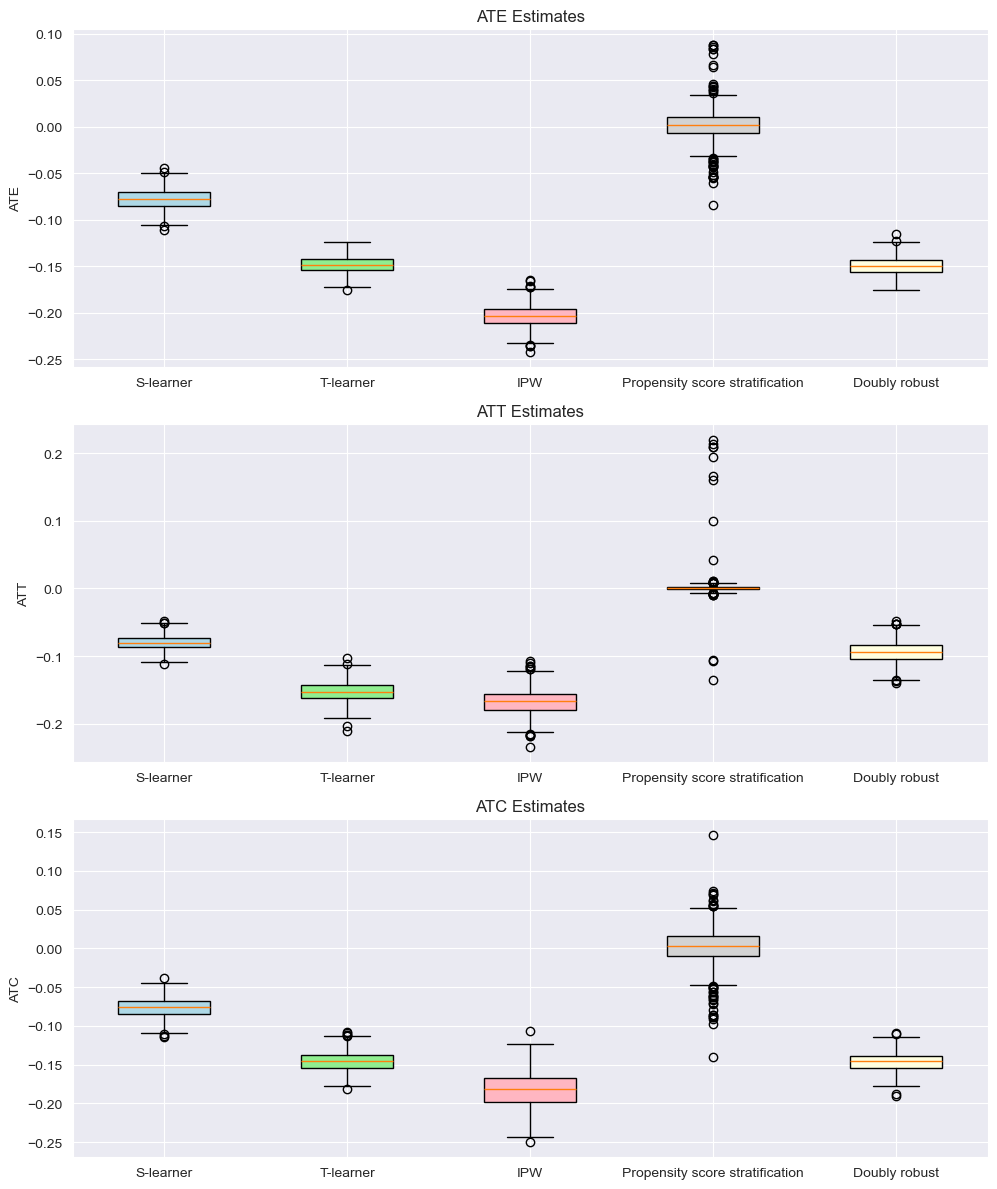

In [55]:
# Plot the ATE, ATT, and ATC estimates for each method
ATE_values = [method_bootstrap_values[method]['ATE'] for method in method_bootstrap_values]
ATT_values = [method_bootstrap_values[method]['ATT'] for method in method_bootstrap_values]
ATC_values = [method_bootstrap_values[method]['ATC'] for method in method_bootstrap_values]

ATE_CIs = [method_CIs[method]['ATE_CI'] for method in method_CIs]
ATT_CIs = [method_CIs[method]['ATT_CI'] for method in method_CIs]
ATC_CIs = [method_CIs[method]['ATC_CI'] for method in method_CIs]

colors = ['lightblue', 'lightgreen', 'lightpink', 'lightgrey', 'lightyellow']

plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)  
boxes_ate = plt.boxplot(ATE_values, patch_artist=True, labels=list(method_bootstrap_values.keys()))
for patch, color in zip(boxes_ate['boxes'], colors):
    patch.set_facecolor(color)
plt.title('ATE Estimates')
plt.ylabel('ATE')

plt.subplot(3, 1, 2) 
boxes_att = plt.boxplot(ATT_values, patch_artist=True, labels=list(method_bootstrap_values.keys()))
for patch, color in zip(boxes_att['boxes'], colors):
    patch.set_facecolor(color)
plt.title('ATT Estimates')
plt.ylabel('ATT')

plt.subplot(3, 1, 3) 
boxes_atc = plt.boxplot(ATC_values, patch_artist=True, labels=list(method_bootstrap_values.keys()))
for patch, color in zip(boxes_atc['boxes'], colors):
    patch.set_facecolor(color)
plt.title('ATC Estimates')
plt.ylabel('ATC')

plt.subplots_adjust(hspace=0.8)
plt.tight_layout()
plt.show()

# Important Features for $Y \mid X, t$

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Fit a Random Forest Classifier model to predict the target variable
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

feature_scores = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

Admission grade                   0.101284
Previous qualification (grade)    0.086080
Scholarship holder_1              0.053898
Unemployment rate                 0.047076
GDP                               0.046948
                                    ...   
Application mode_15               0.000133
Application mode_2                0.000119
Application order_9               0.000000
Application mode_27               0.000000
Application mode_26               0.000000
Length: 84, dtype: float64

/var/folders/17/scnm7xq14yq9ygzbq238tccw0000gn/T/ipykernel_42456/1355255484.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=feature_scores, y=feature_scores.index, palette=palette)
/var/folders/17/scnm7xq14yq9ygzbq238tccw0000gn/T/ipykernel_42456/1355255484.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_scores.index)


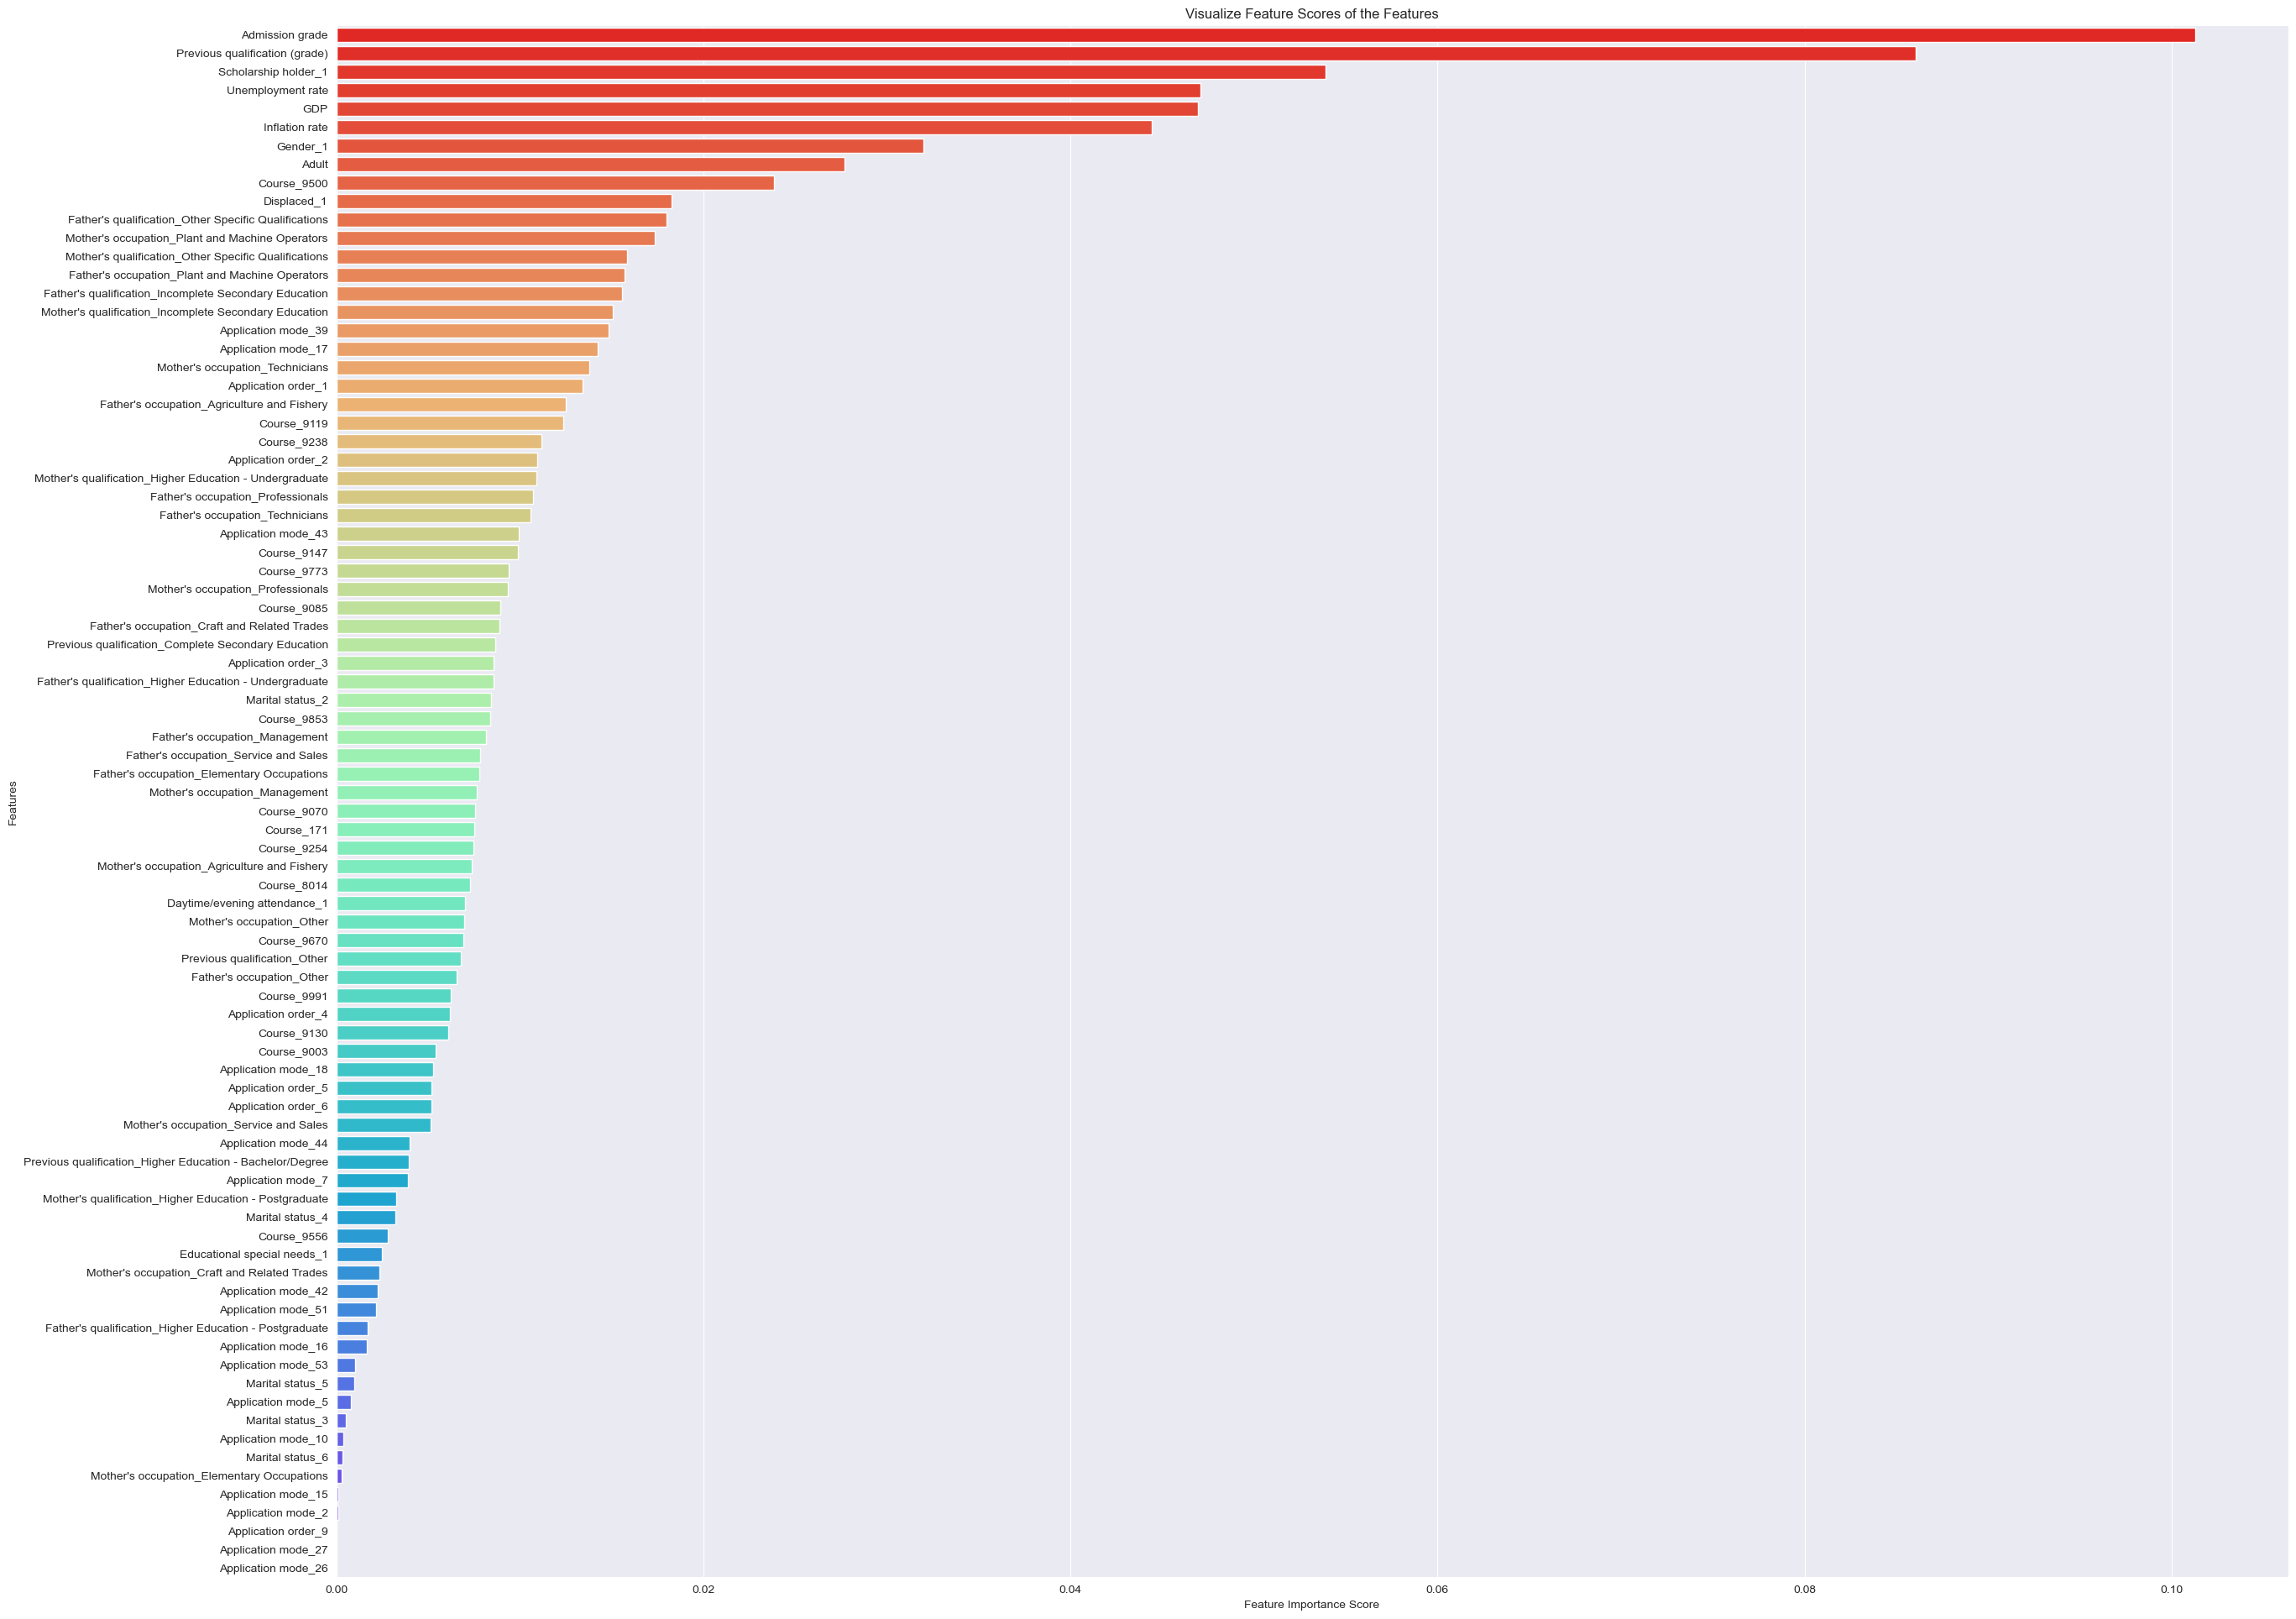

In [57]:
num_features = len(feature_scores)
palette = sns.color_palette("rainbow", num_features)[::-1]  

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, palette=palette)
ax.set_title("Visualize Feature Scores of the Features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
plt.show()

# Important Features for $T \mid X$

Feature Importances for T | X:
Application mode_39                                    0.157960
Admission grade                                        0.073477
Previous qualification (grade)                         0.062232
Previous qualification_Complete Secondary Education    0.052451
Daytime/evening attendance_1                           0.041563
                                                         ...   
Mother's occupation_Elementary Occupations             0.000134
Application mode_15                                    0.000078
Application mode_26                                    0.000054
Application order_9                                    0.000000
Application mode_27                                    0.000000
Length: 83, dtype: float64


/var/folders/17/scnm7xq14yq9ygzbq238tccw0000gn/T/ipykernel_42456/328334490.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=feature_scores_t, y=feature_scores_t.index, palette=palette)


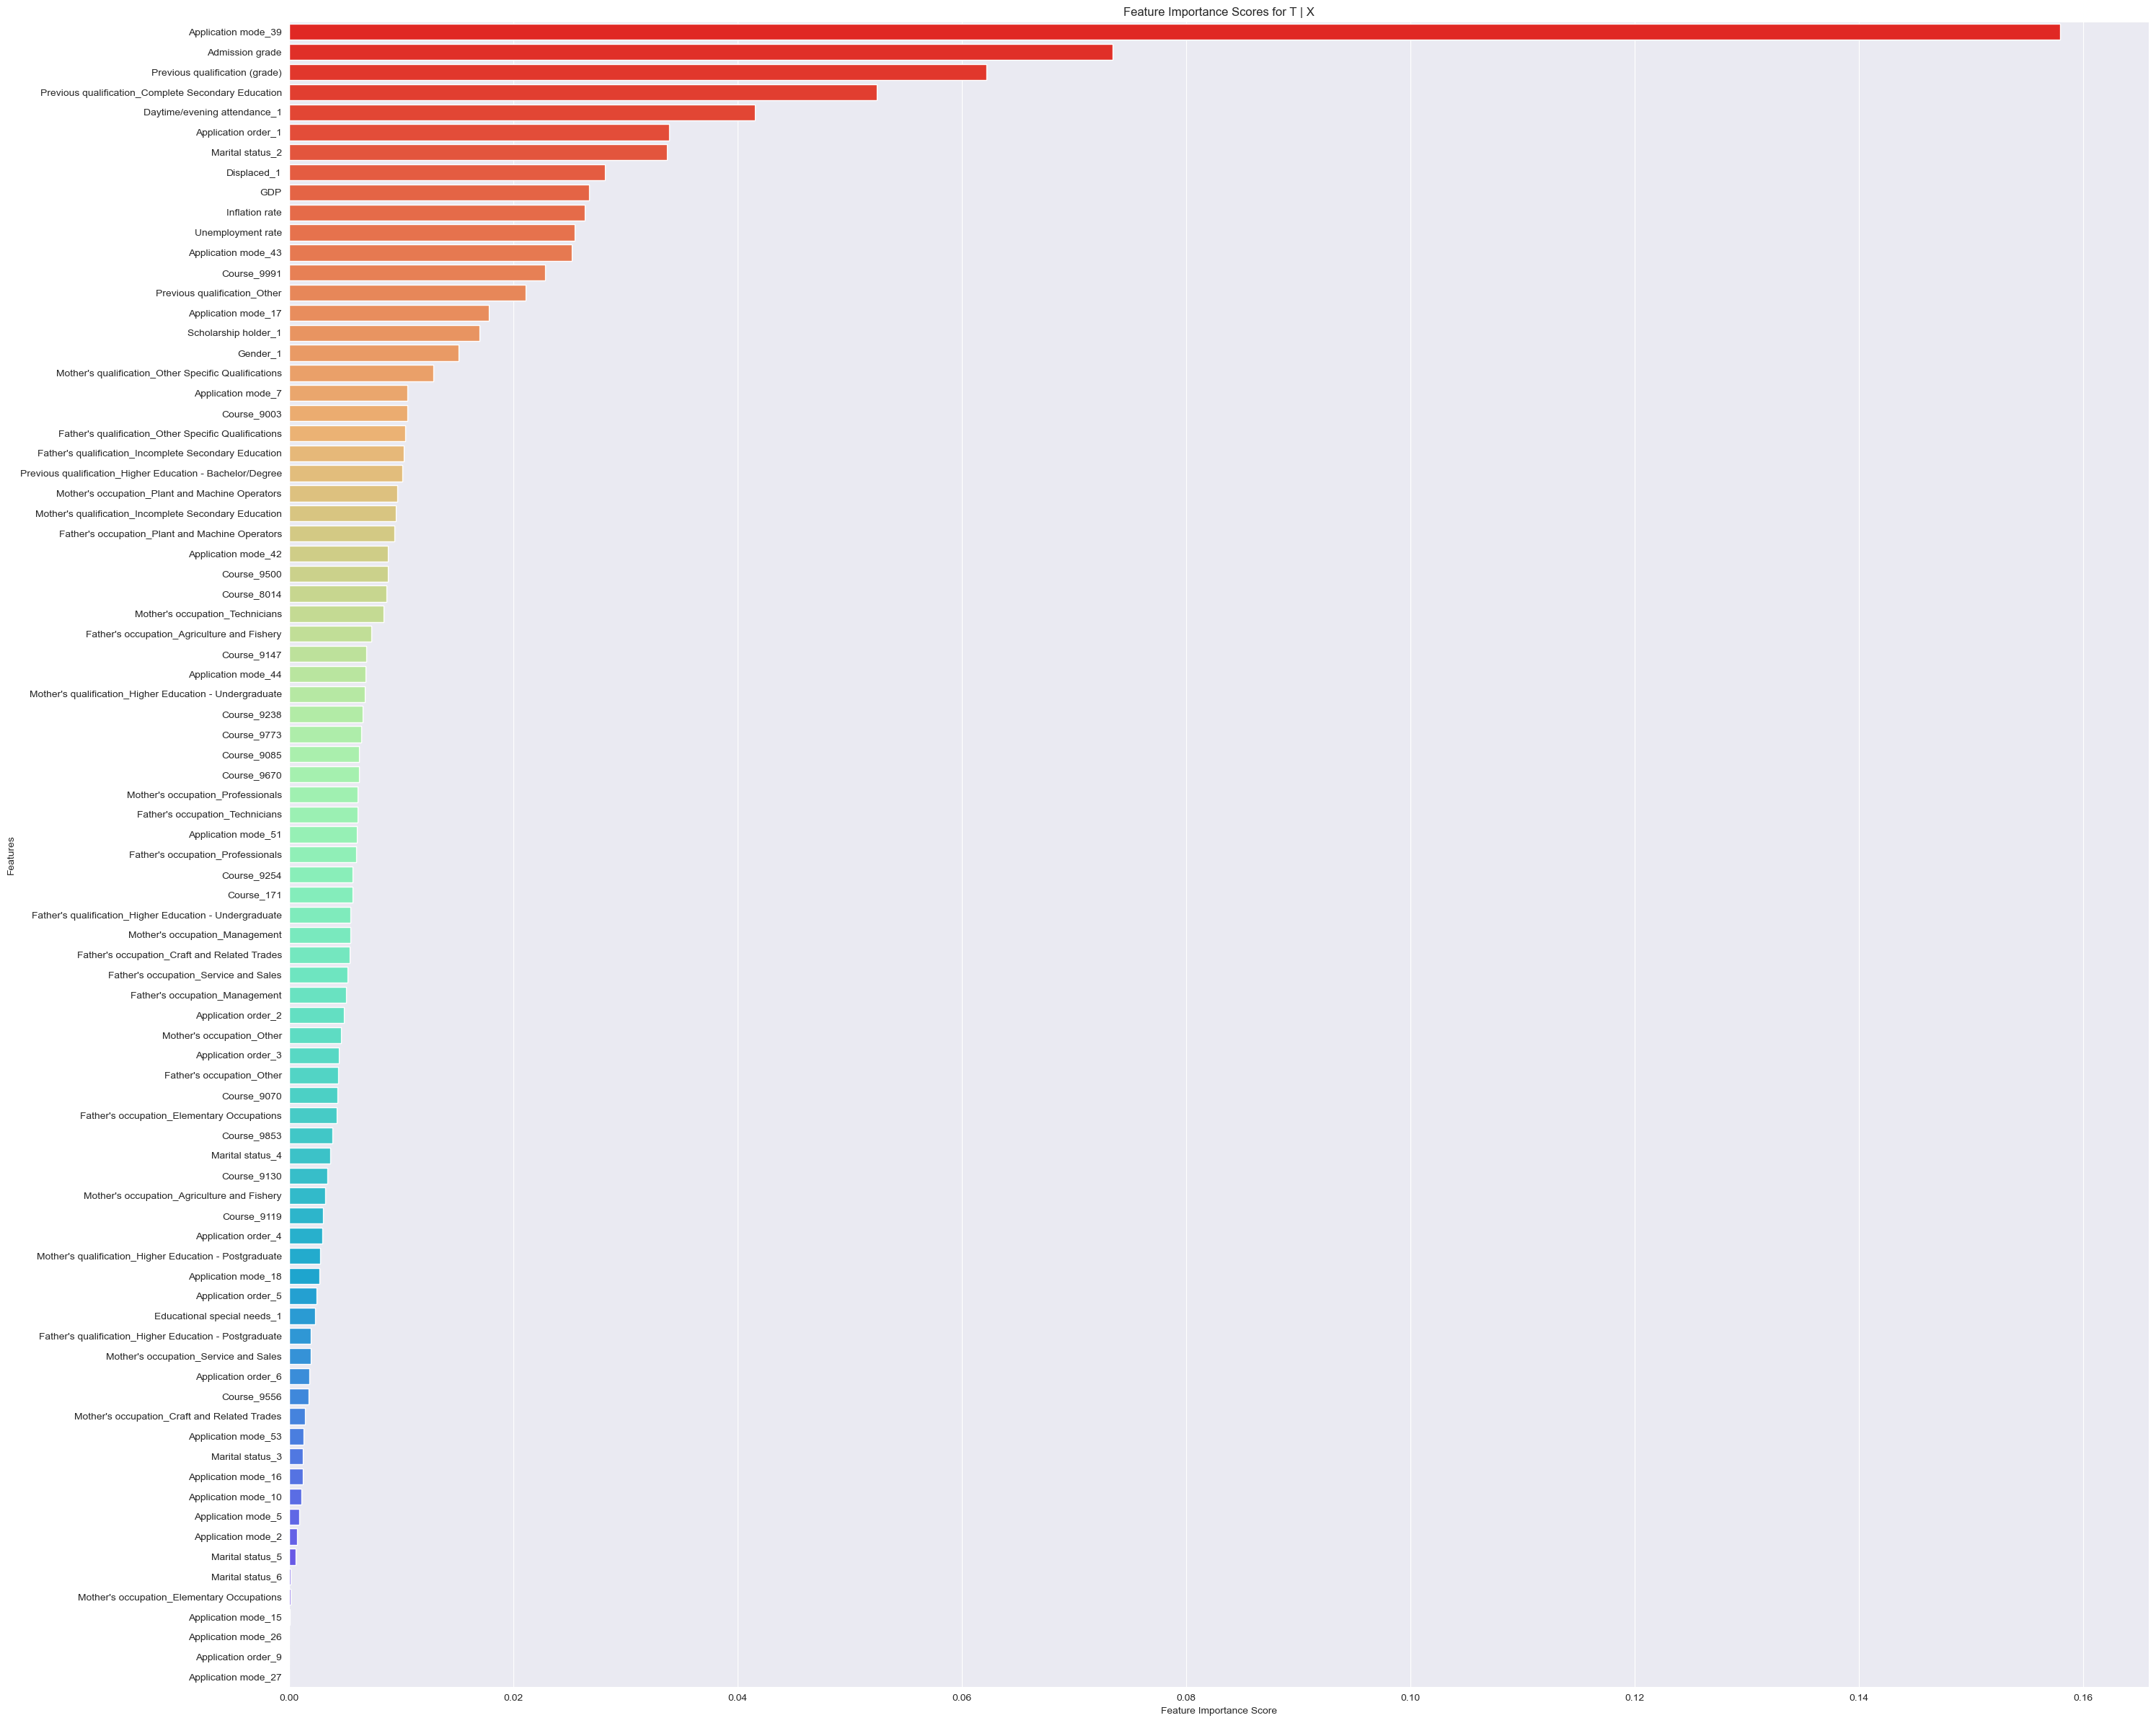

In [58]:
# Split the data into training and testing sets
X_train_t, X_test_t, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=42)

# Fit a Random Forest Classifier model to predict the treatment variable
model_rf_t = RandomForestClassifier(random_state=42)
model_rf_t.fit(X_train_t, t_train)

# Calculate feature importances
feature_scores_t = pd.Series(model_rf_t.feature_importances_, index=X_train_t.columns).sort_values(ascending=False)

# Display feature importances
print("Feature Importances for T | X:")
print(feature_scores_t)

# Visualize feature importances
num_features = len(feature_scores_t)
palette = sns.color_palette("rainbow", num_features)[::-1]  

plt.figure(figsize=(30, 24))
ax = sns.barplot(x=feature_scores_t, y=feature_scores_t.index, palette=palette)
ax.set_title("Feature Importance Scores for T | X")
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()